<a href="https://colab.research.google.com/github/DanielRZO/Algoritmo_Genetico_problema_de_ordem/blob/main/Trabalho_BI_master_Otimiza%C3%A7%C3%A3o_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Distribuição de vacinas contra covid em postos de vacinação Zona Sul do Rio

Imagine quem uma situação de emergência, chegaram vacinas no aeroporo Santos Dummont para distribuição em 20 pontos de vacinação da Zona Sul Rio de Janeiro. Por questões de Logistica as vacinas que chegaram no aeroporto Galeão serão distribuídas nas demais regiões da cidade.

Assim o objetivo do trabalho é maximizar uma rota de distribuição para essas regiões.


In [ ]:
import folium
!pip install openrouteservice 
from openrouteservice import client
from shapely import wkt, geometry
import json
from pprint import pprint
from scipy.spatial import distance_matrix
import pandas as pd
import random
import numpy
!pip install deap
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import math

In [ ]:
# chave de acesso para rotas, caso necessário
api_key = 'your key' 

# dimensionamento da figura
from branca.element import Figure
fig=Figure(width=750,height=450)

# inicialemnte visualizaremos um primeiro mapa da zona sul do Rio de Janeiro
m=folium.Map(width=750,height=450, location=[-22.95710445596429, -43.18545729573689], zoom_start=13, min_zoom=8, max_zoom = 15) 
fig.add_child(m)
m

In [ ]:
# aqui adicionaremos os 20 pontos de vacinação escolhidos pela secretaria de saúde, para distribuição das vacinas

#obs.: SMS é posto de saúde

#as marcações ficaram no mapa
folium.Marker(location=[-22.90984609532672, -43.16453481901272],popup='Santos_Dumont',tooltip='Click here to see Popup').add_to(m) #0
folium.Marker(location=[-22.961542179910733, -43.21865804016312],popup='ABBR',tooltip='Click here to see Popup').add_to(m) #1
folium.Marker(location=[-22.980824138520926, -43.196170400227025],popup='SMS_Cantagalo',tooltip='Click here to see Popup').add_to(m) #2
folium.Marker(location=[-22.982878611270564, -43.18999059077894],popup='Hotel_Fairmont',tooltip='Click here to see Popup').add_to(m) #3
folium.Marker(location=[-22.993056213757274, -43.234514089931956],popup='SMS_Rodolpho',tooltip='Click here to see Popup').add_to(m) #4
folium.Marker(location=[-22.976046350999486, -43.222677436582906],popup='SMS_Pad_Miguel',tooltip='Click here to see Popup').add_to(m) #5
folium.Marker(location=[-22.97453236829065, -43.23068921451901],popup='Planetario',tooltip='Click here to see Popup').add_to(m) #6
folium.Marker(location=[-22.966471836602683, -43.18743054810058],popup='SMS_JoaBarros',tooltip='Click here to see Popup').add_to(m) #7
folium.Marker(location=[-22.9580946963788, -43.17163770179098],popup='SMS_ChapeuMang',tooltip='Click here to see Popup').add_to(m) #8
folium.Marker(location=[-22.961615032735804, -43.16969176144102],popup='Paroquia_Rosario',tooltip='Click here to see Popup').add_to(m) #9
folium.Marker(location=[-22.956908837230625, -43.19922559314023],popup='Bombeiro_Humaita',tooltip='Click here to see Popup').add_to(m) #10
folium.Marker(location=[-22.949163404648825, -43.192959953005364],popup='SMS_DonaMarta',tooltip='Click here to see Popup').add_to(m) #11
folium.Marker(location=[-22.951060286280853, -43.18635099012338],popup='SMS_DomHelter',tooltip='Click here to see Popup').add_to(m) #12
folium.Marker(location=[-22.949479553434184, -43.189269233473865],popup='Casa_Firjan',tooltip='Click here to see Popup').add_to(m) #13
folium.Marker(location=[-22.952482930053158, -43.17218892680484],popup='Inst_Benjamin',tooltip='Click here to see Popup').add_to(m) #14
folium.Marker(location=[-22.9252634072209, -43.17883808757883],popup='SMS_Manoel',tooltip='Click here to see Popup').add_to(m) #15
folium.Marker(location=[-22.92558945200113, -43.17631717131938],popup='Museu_Republica',tooltip='Click here to see Popup').add_to(m) #16
folium.Marker(location=[-22.952991968665895, -43.17672013096345],popup='RochaMaia',tooltip='Click here to see Popup').add_to(m) #17
folium.Marker(location=[-22.972828312011444, -43.22298287113733],popup='Jockey',tooltip='Click here to see Popup').add_to(m) #18
folium.Marker(location=[-22.993072809149222, -43.24392819385125],popup='SMS_Rinaldo',tooltip='Click here to see Popup').add_to(m) #19
m

In [ ]:
# criando a base para otimizar a rota

latlong = [[-22.90984609532672, -43.16453481901272], [-22.961542179910733, -43.21865804016312], [-22.980824138520926, -43.196170400227025],
           [-22.982878611270564, -43.18999059077894], [-22.993056213757274, -43.234514089931956], [-22.976046350999486, -43.222677436582906],
           [-22.97453236829065, -43.23068921451901], [-22.966471836602683, -43.18743054810058], [-22.9580946963788, -43.17163770179098], 
           [-22.961615032735804, -43.16969176144102], [-22.956908837230625, -43.19922559314023], [-22.949163404648825, -43.192959953005364],
           [-22.951060286280853, -43.18635099012338], [-22.949479553434184, -43.189269233473865], [-22.952482930053158, -43.17218892680484],
           [-22.9252634072209, -43.17883808757883], [-22.92558945200113, -43.17631717131938], [-22.952991968665895, -43.17672013096345],
           [-22.972828312011444, -43.22298287113733], [-22.993072809149222, -43.24392819385125]]

postos = ['Santos_Dumont', 'ABBR', 'SMS_Cantagalo', 'Hotel_Fairmont', 'SMS_Rodolpho', 'SMS_Pad_Miguel', 'Planetario', 'SMS_JoaBarros', 'SMS_ChapeuMang',
          'Paroquia_Rosario', 'Bombeiro_Humaita', 'SMS_DonaMarta', 'SMS_DomHelter', 'Casa_Firjan', 'Inst_Benjamin', 'SMS_Manoel', 'Museu_Republica',
          'RochaMaia', 'Jockey', 'SMS_Rinaldo' ]

df = pd.DataFrame(latlong, columns=['xcord', 'ycord'], index=postos)

df


,xcord,ycord
Santos_Dumont,-22.909846,-43.164535
ABBR,-22.961542,-43.218658
SMS_Cantagalo,-22.980824,-43.196170
Hotel_Fairmont,-22.982879,-43.189991
SMS_Rodolpho,-22.993056,-43.234514
SMS_Pad_Miguel,-22.976046,-43.222677
Planetario,-22.974532,-43.230689
SMS_JoaBarros,-22.966472,-43.187431
SMS_ChapeuMang,-22.958095,-43.171638
Paroquia_Rosario,-22.961615,-43.169692


In [ ]:
# criando a matriz de distancias 

cities = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
cities

,Santos_Dumont,ABBR,SMS_Cantagalo,Hotel_Fairmont,SMS_Rodolpho,SMS_Pad_Miguel,Planetario,SMS_JoaBarros,SMS_ChapeuMang,Paroquia_Rosario,Bombeiro_Humaita,SMS_DonaMarta,SMS_DomHelter,Casa_Firjan,Inst_Benjamin,SMS_Manoel,Museu_Republica,RochaMaia,Jockey,SMS_Rinaldo
Santos_Dumont,0.000000,0.074845,0.077709,0.077342,0.108725,0.088108,0.092524,0.061079,0.048769,0.052025,0.058467,0.048516,0.046632,0.046718,0.043318,0.021030,0.019664,0.044834,0.085924,0.115022
ABBR,0.074845,0.000000,0.029622,0.035736,0.035278,0.015051,0.017706,0.031614,0.047147,0.048966,0.019977,0.028524,0.033965,0.031768,0.047344,0.053868,0.055546,0.042801,0.012086,0.040407
SMS_Cantagalo,0.077709,0.029622,0.000000,0.006512,0.040248,0.026934,0.035088,0.016804,0.033444,0.032713,0.024110,0.031823,0.031342,0.032095,0.037126,0.058201,0.058694,0.033955,0.027979,0.049304
Hotel_Fairmont,0.077342,0.035736,0.006512,0.000000,0.045672,0.033393,0.041546,0.016605,0.030839,0.029397,0.027563,0.033846,0.032026,0.033407,0.035225,0.058685,0.058898,0.032700,0.034489,0.054893
SMS_Rodolpho,0.108725,0.035278,0.040248,0.045672,0.000000,0.020723,0.018915,0.054070,0.071943,0.072045,0.050516,0.060443,0.063901,0.062817,0.074368,0.087725,0.089099,0.070323,0.023284,0.009414
SMS_Pad_Miguel,0.088108,0.015051,0.026934,0.033393,0.020723,0.000000,0.008154,0.036524,0.054105,0.054916,0.030269,0.040073,0.044090,0.042684,0.055716,0.067088,0.068521,0.051416,0.003233,0.027230
Planetario,0.092524,0.017706,0.035088,0.041546,0.018915,0.008154,0.000000,0.044003,0.061297,0.062350,0.036063,0.045465,0.050168,0.048407,0.062518,0.071526,0.073156,0.058109,0.007892,0.022782
SMS_JoaBarros,0.061079,0.031614,0.016804,0.016605,0.054070,0.036524,0.044003,0.000000,0.017877,0.018392,0.015185,0.018170,0.015449,0.017091,0.020688,0.042095,0.042366,0.017217,0.036116,0.062447
SMS_ChapeuMang,0.048769,0.047147,0.033444,0.030839,0.071943,0.054105,0.061297,0.017877,0.000000,0.004022,0.027613,0.023117,0.016308,0.019624,0.005639,0.033612,0.032840,0.007202,0.053417,0.080308
Paroquia_Rosario,0.052025,0.048966,0.032713,0.029397,0.072045,0.054916,0.062350,0.018392,0.004022,0.000000,0.029906,0.026390,0.019721,0.023034,0.009467,0.037485,0.036630,0.011125,0.054458,0.080627


### Declaração das funções auxiliares que devem conter as informações do problema

In [ ]:
random.sample(range(0,10),10)

[8, 1, 2, 4, 7, 6, 0, 9, 5, 3]

In [ ]:
# Função Objetivo -> Repare que o único parametro que a função deve receber é um individuo
def DistanciaCidades(individual):
  totalCidades = len(individual)
  distanciaTotal = 0
  for index,cidade in enumerate(individual):
    # Verificar a distancia de uma cidade para a outra
    cidadeOrigem = cidade
    cidadeDestino = individual[index+1]
    distanciaTotal = distanciaTotal + cities.iloc[cidadeOrigem,cidadeDestino]
    # Para um problema circular deve-se alterar a validação abaixo
    if index == len(individual) -2: # Tamanho total da lista -1 é o valor que a variavel index alcança, e -1 novamente para não rodar no loop de novo
      cidadeDestino = individual[index+0]  # para problema circular - voltar para o mesmo lugar
      distanciaTotal = distanciaTotal + cities.iloc[cidadeOrigem,cidadeDestino]
      break
  return distanciaTotal,

### Declaração dos pacotes referentes a biblioteca do GA: 



In [ ]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
toolbox = base.Toolbox()
# Definir o gerador de numeros aleatórios únicos de numeros inteiros de (0 a 20)
toolbox.register("random_unique_int", random.sample, range(0,20), 20) # range é o vetor de possibilidades
# Inicialização do cromossomo (quantos genes o cromossomo deve possuir)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.random_unique_int)
# Registro do individuo na população
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# Registro do nome da função objetivo
toolbox.register("evaluate", DistanciaCidades)

#################################### OPERADORES ####################################
# Registro de qual o tipo de cruzamento deve ser utilizado (Recomendado para problema de Ordem)
toolbox.register("mate", tools.cxOrdered)
# Registro de qual tipo de mutação deve ser utilizado (Recomendado para problema de Ordem) (probabilidade de um individuo sofrer mutação)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)
# Registro de qual o tipo do método de seleção que será utilizado
toolbox.register("select", tools.selTournament, tournsize=5) #cuidado com o metodo de seleção de roleta no metodo de minimização

## Chamada efetiva do GA para resolução

In [ ]:
pop = toolbox.population(n=400)                           # inicialização da pop
hof = tools.HallOfFame(1)                                 # melhor indivíduo
stats = tools.Statistics(lambda ind: ind.fitness.values)  # estatísticas
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

In [ ]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.3, ngen=80, stats=stats, halloffame=hof, verbose=True) #aumentei mut = 0.7

gen	nevals	avg     	std     	min     	max     
0  	400   	0.756438	0.079443	0.501245	0.969483
1  	314   	0.682763	0.0679521	0.501245	0.901505
2  	317   	0.645256	0.0718538	0.419974	0.90366 
3  	314   	0.609325	0.0721905	0.419974	0.853318
4  	322   	0.579289	0.074994 	0.419974	0.801174
5  	279   	0.548519	0.08035  	0.394188	0.964948
6  	313   	0.531955	0.0779443	0.377381	0.794464
7  	315   	0.519157	0.0846294	0.366049	0.853755
8  	310   	0.507686	0.0897062	0.372837	0.822189
9  	325   	0.483644	0.0813493	0.353619	0.839754
10 	320   	0.480427	0.096502 	0.345778	0.830089
11 	296   	0.457471	0.0871041	0.336112	0.819544
12 	322   	0.447296	0.0908806	0.331413	0.863383
13 	325   	0.434619	0.0854659	0.32633 	0.88235 
14 	298   	0.429589	0.0963711	0.318451	0.802032
15 	315   	0.417705	0.0871876	0.318451	0.839377
16 	313   	0.417221	0.0902503	0.31868 	0.86268 
17 	309   	0.411349	0.0925457	0.298181	0.775318
18 	306   	0.408519	0.096091 	0.298181	0.809872
19 	304   	0.404092	0.0937127	0.298181	0.7

## Resultados

In [ ]:
# Melhor solução
print("Melhor Indivíduo:")
print(hof[0])

# Melhor resultado da função objetivo
print("Melhor Resultado da Função Objetivo:")
DistanciaCidades(hof[0])

Melhor Indivíduo:
[17, 14, 8, 9, 7, 3, 2, 4, 19, 6, 5, 18, 1, 10, 11, 13, 12, 15, 16, 0]
Melhor Resultado da Função Objetivo:


(0.23768360323780074,)

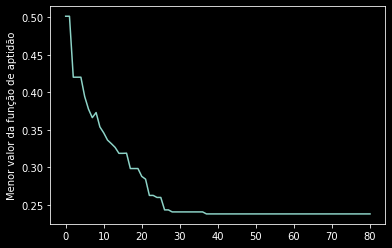

In [ ]:
import matplotlib.pyplot as plt
gen, minVal = log.select("gen", "min")
plt.plot(gen, minVal)
plt.ylabel('Menor valor da função de aptidão')
plt.show()

In [ ]:
# após encontrarmos o melhor resultado, imprimiremos o gráfico dela
#[17, 14, 8, 9, 7, 3, 2, 4, 19, 6, 5, 18, 1, 10, 11, 13, 12, 15, 16, 0]

# sequencia
#Santos_Dumont -> RochaMaia -> Inst_Benjamin -> SMS_ChapeuMang -> Paroquia_Rosario -> SMS_JoaBarros -> Hotel_Fairmont -> SMS_Cantagalo ->
#SMS_Rodolpho -> SMS_Rinaldo -> Planetario -> SMS_Pad_Miguel -> Jockey -> ABBR -> Bombeiro_Humaita -> SMS_DonaMarta -> Casa_Firjan ->
#SMS_DomHelter -> SMS_Manoel -> Museu_Republica -> Santos_Dumont


coords = [[-22.90984609532672, -43.16453481901272],
         [-22.952991968665895, -43.17672013096345], [-22.952482930053158, -43.17218892680484], [-22.9580946963788, -43.17163770179098],
         [-22.961615032735804, -43.16969176144102], [-22.966471836602683, -43.18743054810058], [-22.982878611270564, -43.18999059077894],
         [-22.980824138520926, -43.196170400227025], [-22.982878611270564, -43.18999059077894], [-22.993072809149222, -43.24392819385125],
         [-22.97453236829065, -43.23068921451901], [-22.976046350999486, -43.222677436582906], [-22.972828312011444, -43.22298287113733],
         [-22.961542179910733, -43.21865804016312], [-22.956908837230625, -43.19922559314023], [-22.949163404648825, -43.192959953005364],
         [-22.949479553434184, -43.189269233473865], [-22.951060286280853, -43.18635099012338], [-22.9252634072209, -43.17883808757883],
         [-22.92558945200113, -43.17631717131938], [-22.90984609532672, -43.16453481901272]]


# vizualição do mapa com pontos e rotas
folium.PolyLine(coords,
                color='red',
                weight=5,
                opacity=0.3).add_to(m)
m
